# Lab CMBLenses

## Model

In [1]:
] activate "/home/jaimerz/julia_repos/CMBLensingInferenceTestProblem"

  Activating project at `~/julia_repos/CMBLensingInferenceTestProblem`


In [2]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [3]:
using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [4]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 4);

In [33]:
target = CMBLensingTarget(prob);

In [34]:
function to_from_vec(Ω)
    to_vec(Ω) = Ω[:]
    from_vec(vec) = first(promote(vec, Ω))
    return to_vec, from_vec
end

to_vec, from_vec = to_from_vec(prob.Ωstart)

(to_vec, from_vec)

In [35]:
x = prob.Ωstart

50-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  0.23362982273101807
  1.6145217418670654
 -1.8872356414794922
  ⋮
 -1.6094379124341003
  0.0

In [36]:
xx = from_vec(to_vec(prob.Ωstart))

50-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Base.ReshapedArray{Float64, 3, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}, Tuple{}}}, LambertMap{Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}, Tuple{}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  0.23362982273101807
  1.6145217418670654
 -1.8872356414794922
  ⋮
 -1.6094379124341003
  0.0

In [39]:
prob(xx)

LoadError: MethodError: no method matching (SubArray{Float64, 2})(::UndefInitializer, ::Int64, ::Int64)

In [20]:
prob(from_vec(x))

LoadError: MethodError: no method matching (SubArray{Float64, 2})(::UndefInitializer, ::Int64, ::Int64)

In [15]:
to_vec(prob.Ωstart)

50-element Vector{Float64}:
  0.23362982273101807
  1.6145217418670654
 -1.8872356414794922
  ⋮
 -1.6094379124341003
  0.0

In [12]:
target.inv_transform(x)

LoadError: MethodError: no method matching (SubArray{Float64, 3})(::UndefInitializer, ::Int64, ::Int64, ::Int64)

In [11]:
target.nlogp(x)

LoadError: MethodError: no method matching (SubArray{Float64, 3})(::UndefInitializer, ::Int64, ::Int64, ::Int64)

## Sample

In [8]:
spl=MCHMC(0.1, 0.01*sqrt(50); sigma=one(LenseBasis(diag(target.Λmass))))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 0.2, 0, 1000, 10, "LF"), Hyperparameters(0.1, 0.07071067811865475, 0.0, 0.1931833275037836, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [9]:
samples = Sample(spl, target, 500;
                 monitor_energy=true, dialog=true)

LoadError: MethodError: no method matching (SubArray{Float64, 3})(::UndefInitializer, ::Int64, ::Int64, ::Int64)

## Plotting

In [58]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [59]:
rs = [Vector(sample[1])[end-1] for sample in samples]
Aϕs = [Vector(sample[1])[end] for sample in samples];

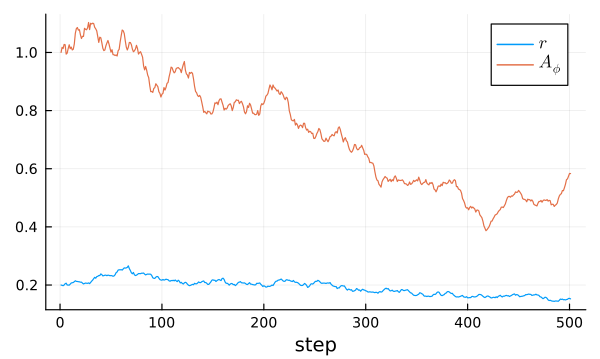

In [60]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")


In [61]:
Energy = [sample[end-1] for sample in samples]

501-element Vector{Float64}:
  0.0
 -0.0002711062021489852
 -0.0004031952767036273
  ⋮
  0.0003882754095911878
  0.0005875684598208863

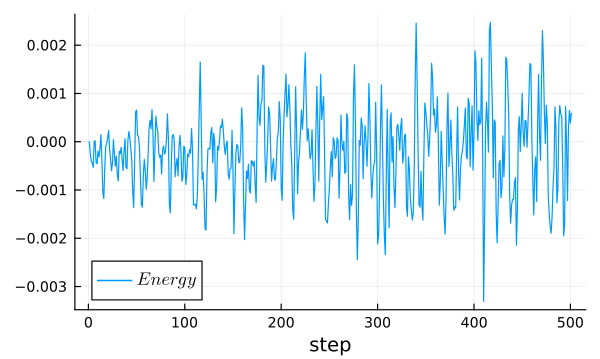

In [62]:
plot(Energy, label=L"Energy", xlabel="step")

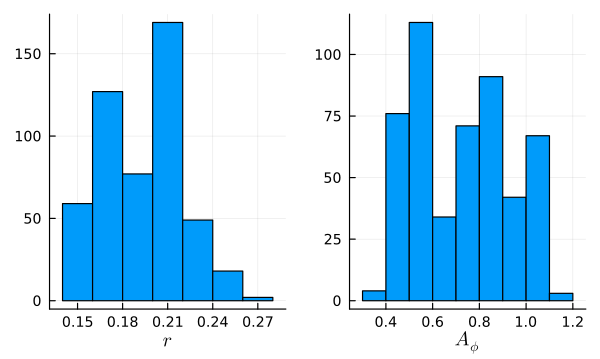

In [63]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))